https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

###  数据加载

数据的下载链接见： https://download.pytorch.org/tutorial/hymenoptera_data.zip

蚂蚁和蜜蜂的二分类问题。每类的训练数据越120张，验证数据约75张。

数据规模非常小！如果从头开始训练一个CNN，会很严重的过拟合，泛化效果非常差。

通过torch的`Dataset`类和`DataLoader`类读取数据：

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

使用`Dataset`获取一个batch的图，并将tensor转换会图像后显示：

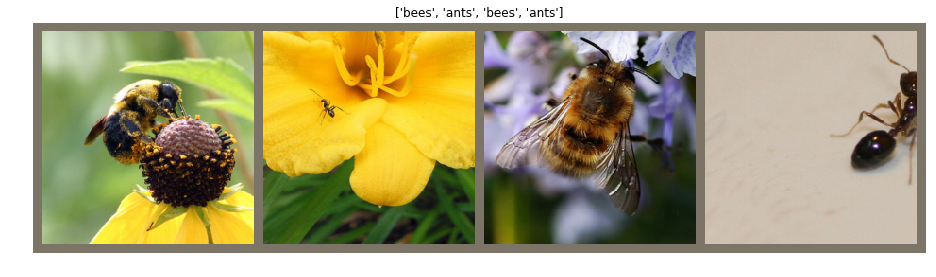

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 64))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

inputs, classes = next(iter(dataloaders['train']))
grid = torchvision.utils.make_grid(inputs, padding=10)

imshow(grid, title=[class_names[x] for x in classes])

### 模型训练基本框架

1. 模型训练过程分为训练和验证
2. 训练的过程中可以调节学习率
3. 保存/加载训练获得的模型文件

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Finetuning

加载一个预训练模型，重新设置全连接层。

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 训练过程

在CPU上需要大约30-60分钟，GPU上不到一分钟。

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4952 Acc: 0.7746
val Loss: 0.1978 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4405 Acc: 0.8033
val Loss: 0.2044 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3758 Acc: 0.8525
val Loss: 0.1726 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3476 Acc: 0.8402
val Loss: 0.2491 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.5790 Acc: 0.7951
val Loss: 0.5342 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.4033 Acc: 0.8525
val Loss: 0.5558 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.6558 Acc: 0.8033
val Loss: 0.3929 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.3846 Acc: 0.8443
val Loss: 0.2971 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3727 Acc: 0.8402
val Loss: 0.2895 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3444 Acc: 0.8607
val Loss: 0.2640 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2927 Acc: 0.8566
val Loss: 0.2942 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2850 Acc: 0.8689
val Loss: 0.3671 Acc: 0.8824

Ep

### 可视化结果

显示一些图片和预测结果

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # no grad computation
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

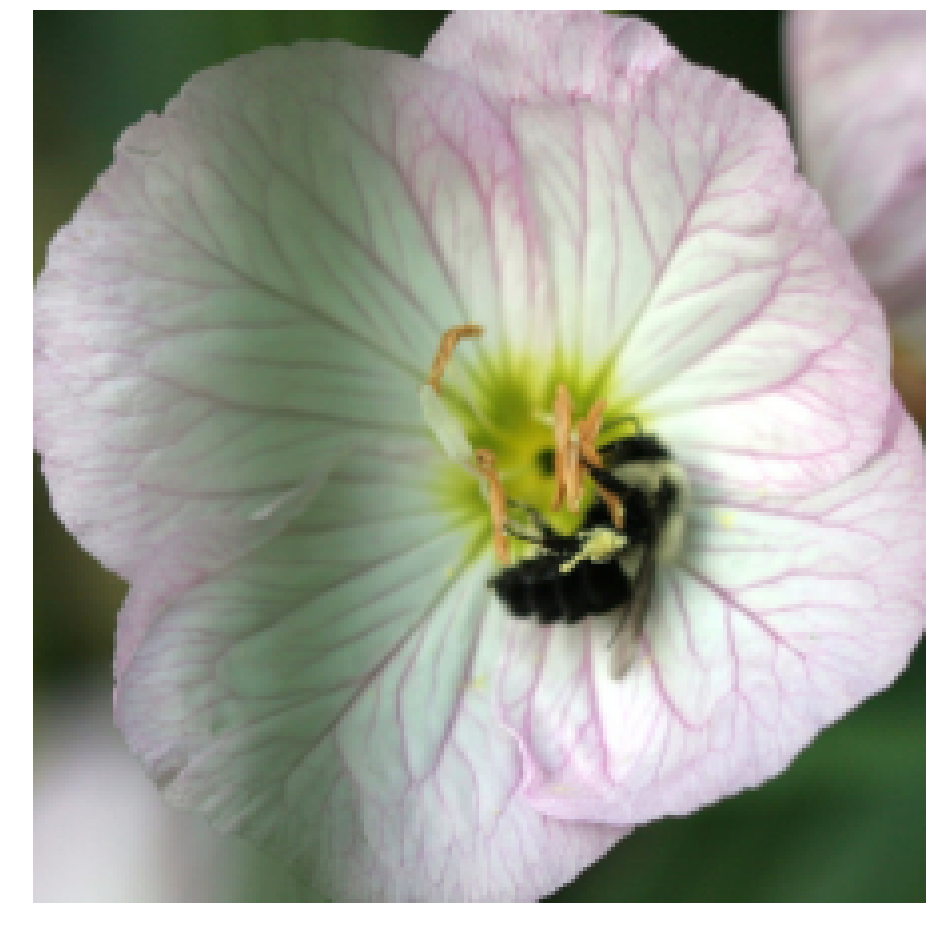

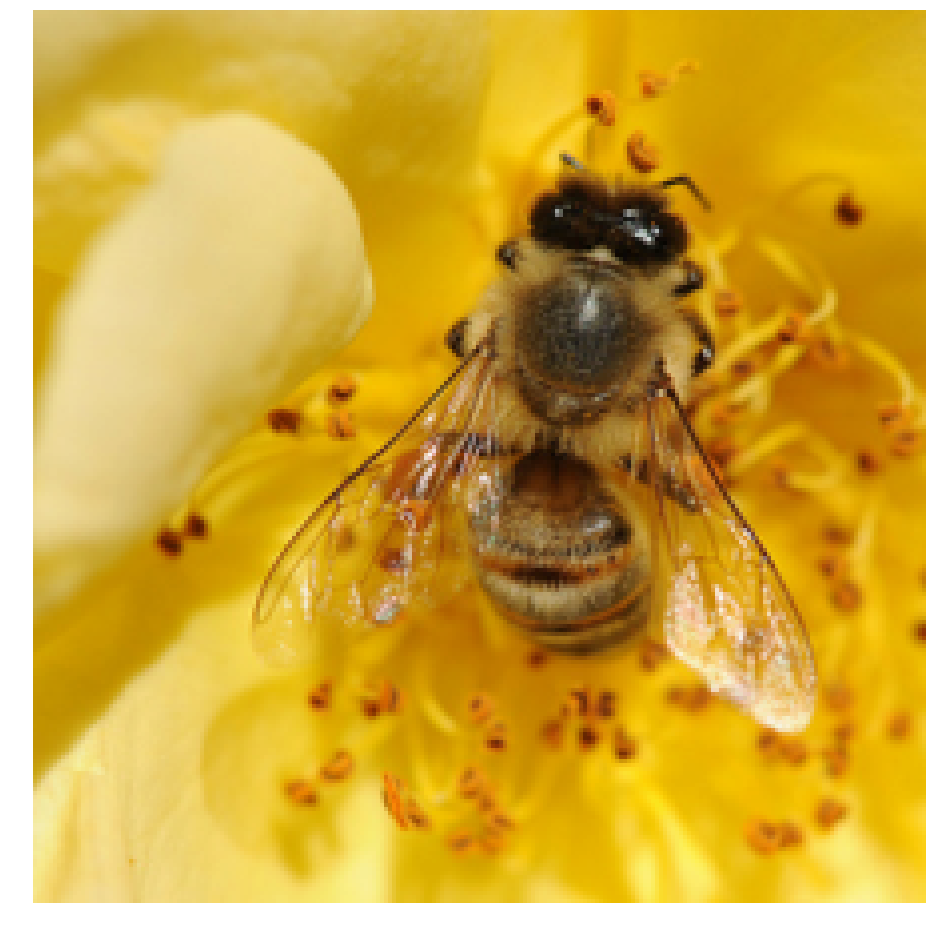

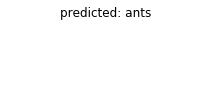

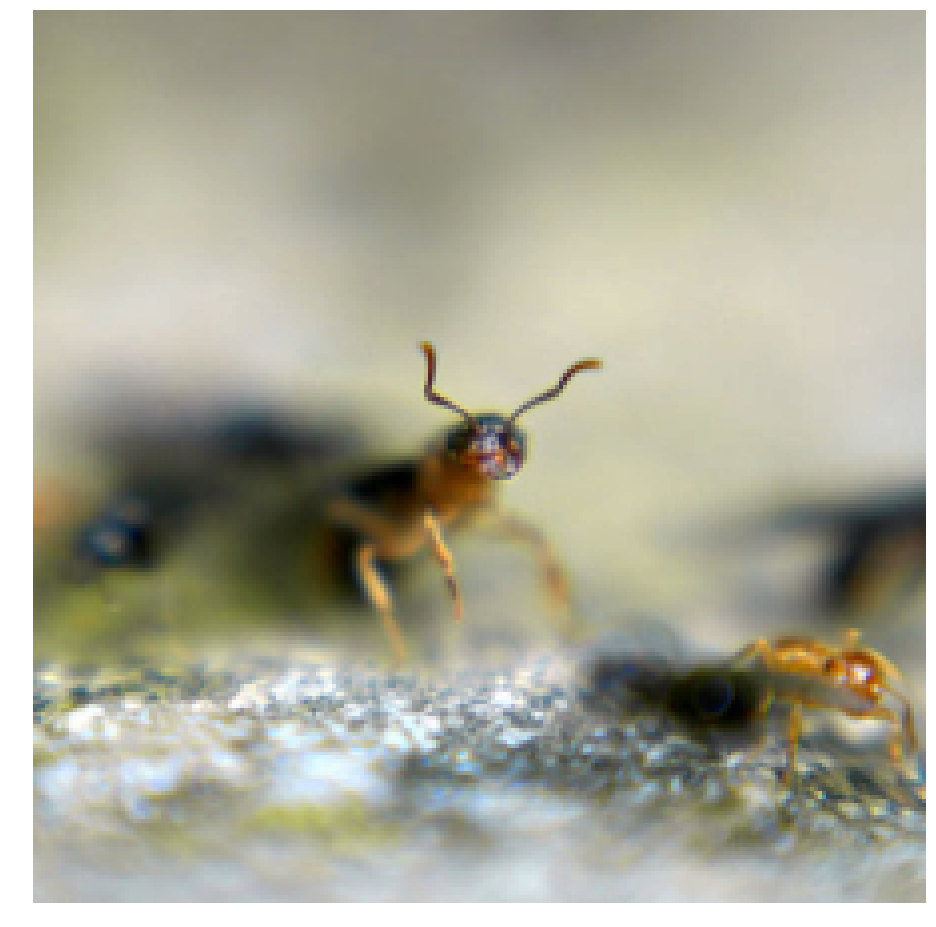

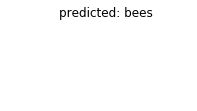

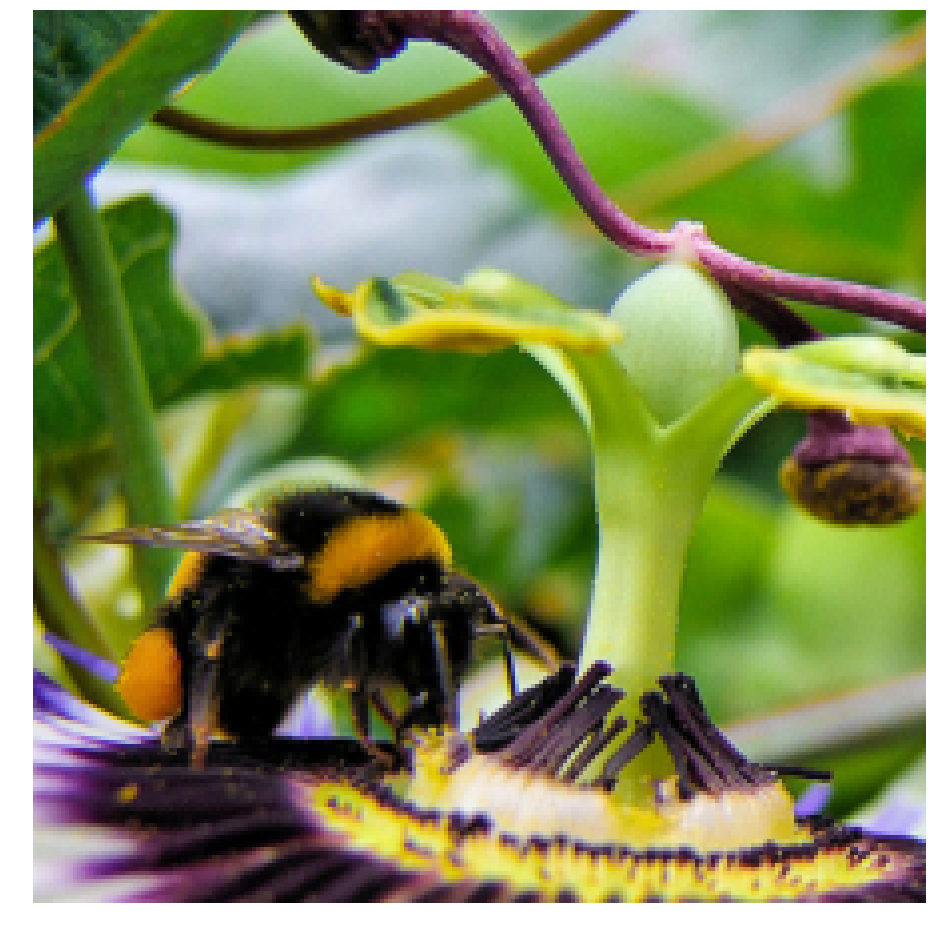

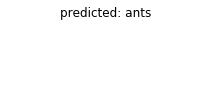

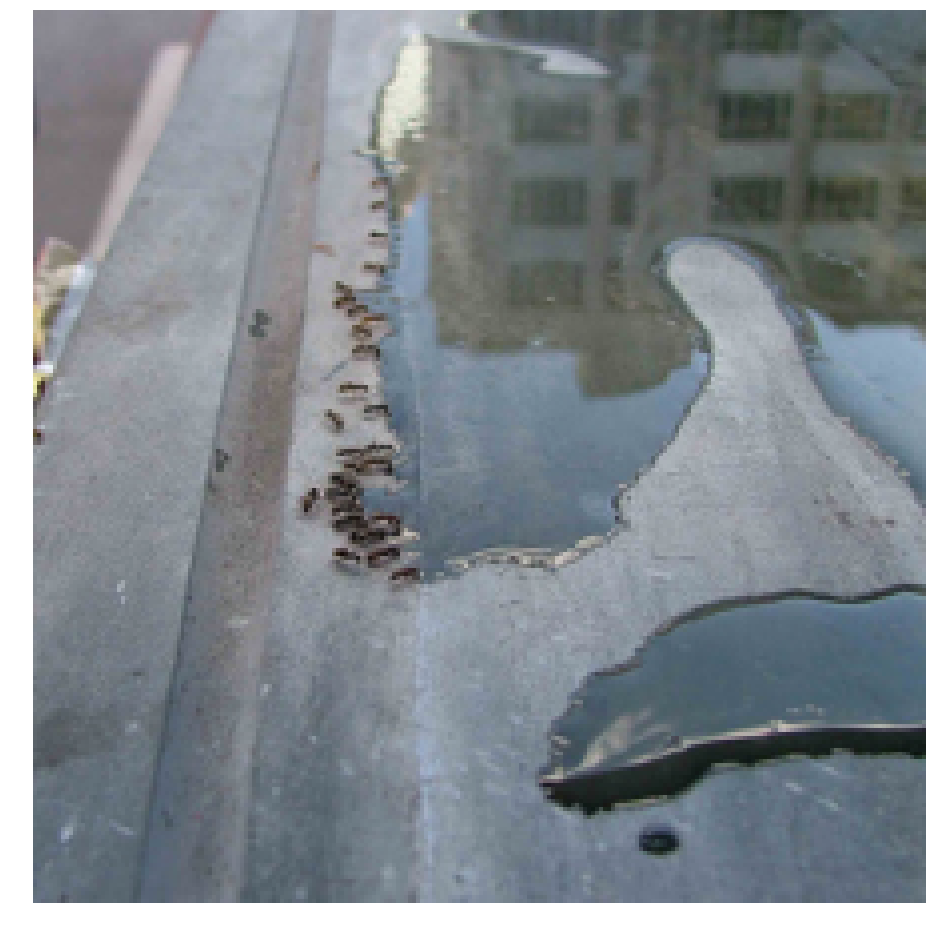

In [16]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor

为了Freeze所有的卷积层，需要设置其`requires_grad == False`，这样在`backward()`的过程中，不会计算梯度，同时也可以减少计算，提高训练速度。

更多参考：https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward




In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练过程

由于节省了在反向传播中的大量梯度计算，可以节约一半的时间。

虽然训练误差较之前下降了，但是验证的误差提升了，表明具有更好的繁华能力。

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5497 Acc: 0.7172
val Loss: 0.2610 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.6094 Acc: 0.7254
val Loss: 0.1802 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4099 Acc: 0.8279
val Loss: 0.2485 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4133 Acc: 0.8238
val Loss: 0.2050 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3954 Acc: 0.8156
val Loss: 0.2097 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3890 Acc: 0.8443
val Loss: 0.1785 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4493 Acc: 0.8115
val Loss: 0.2358 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3403 Acc: 0.8730
val Loss: 0.1875 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3059 Acc: 0.8566
val Loss: 0.1767 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4302 Acc: 0.8238
val Loss: 0.2050 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.4208 Acc: 0.7992
val Loss: 0.1943 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3280 Acc: 0.8402
val Loss: 0.2212 Acc: 0.9216

Ep

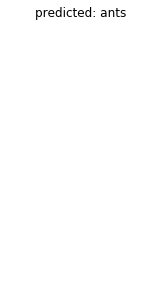

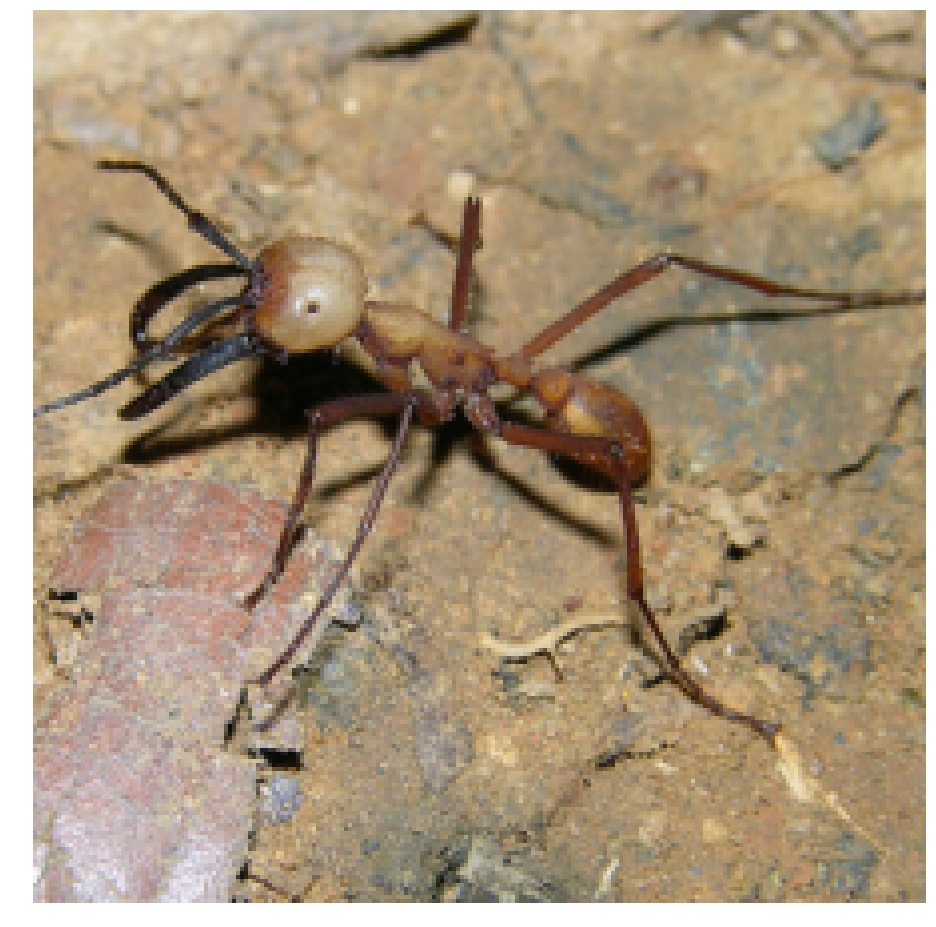

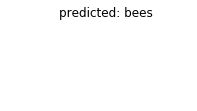

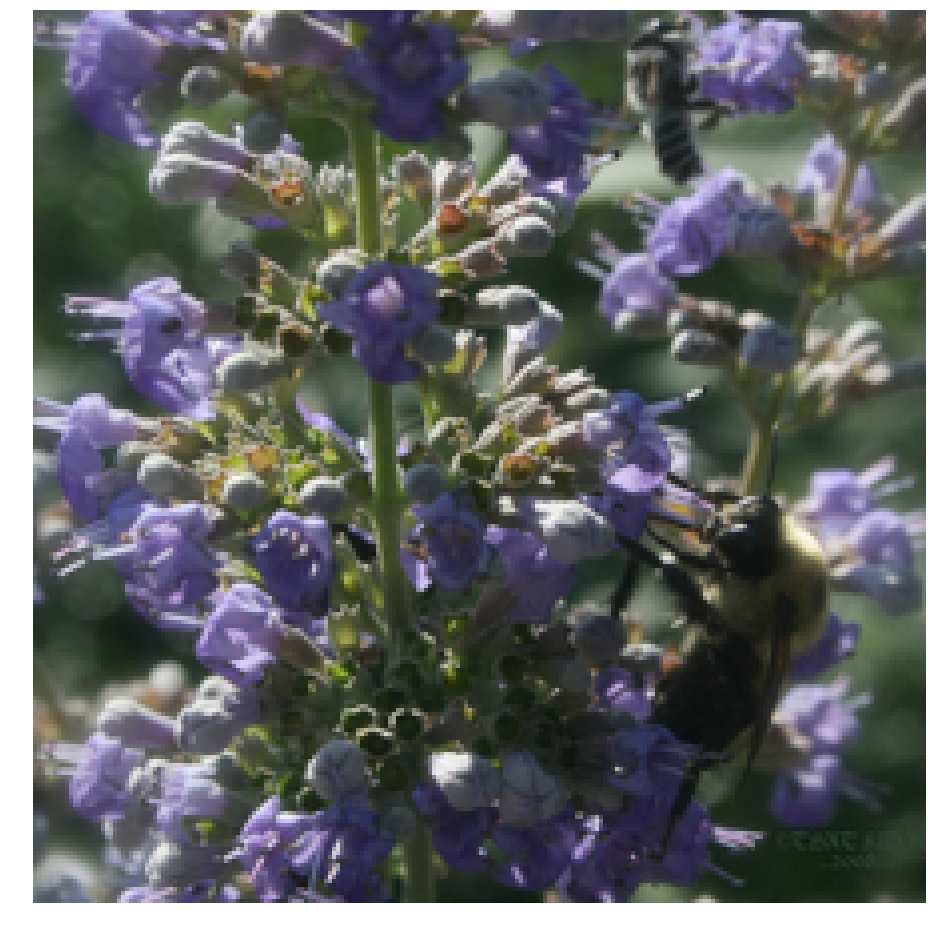

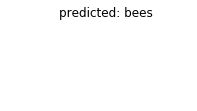

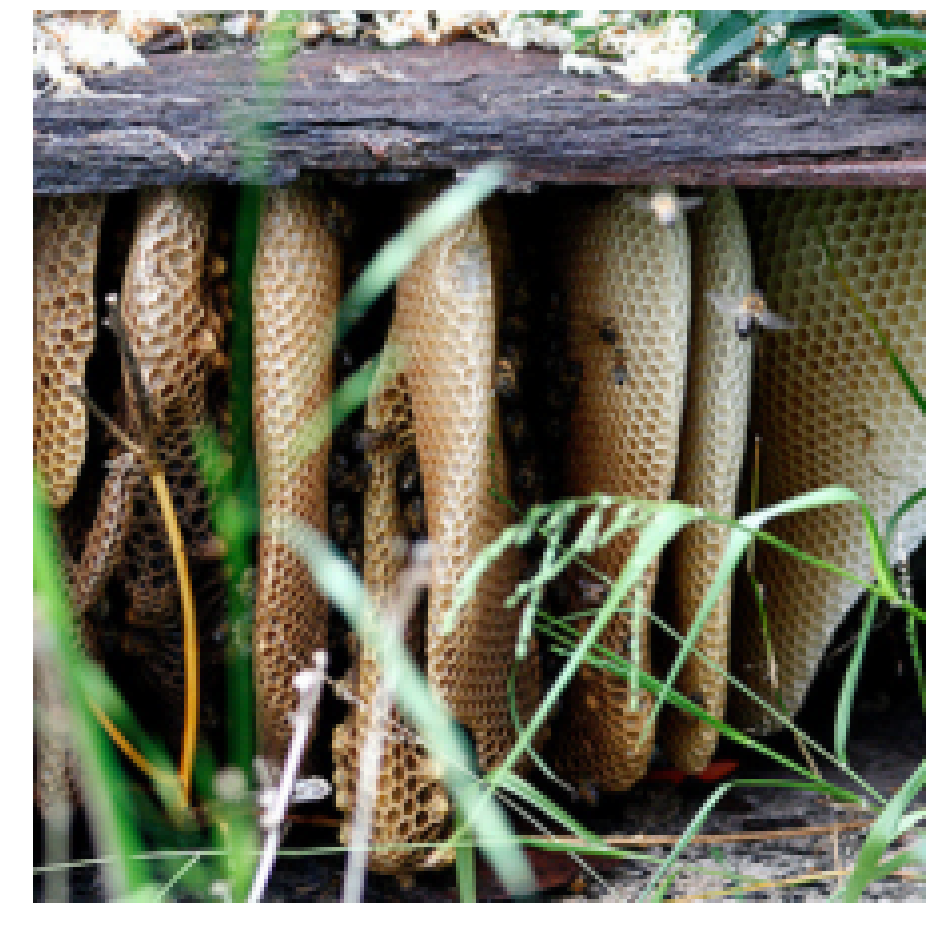

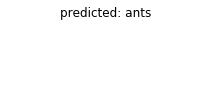

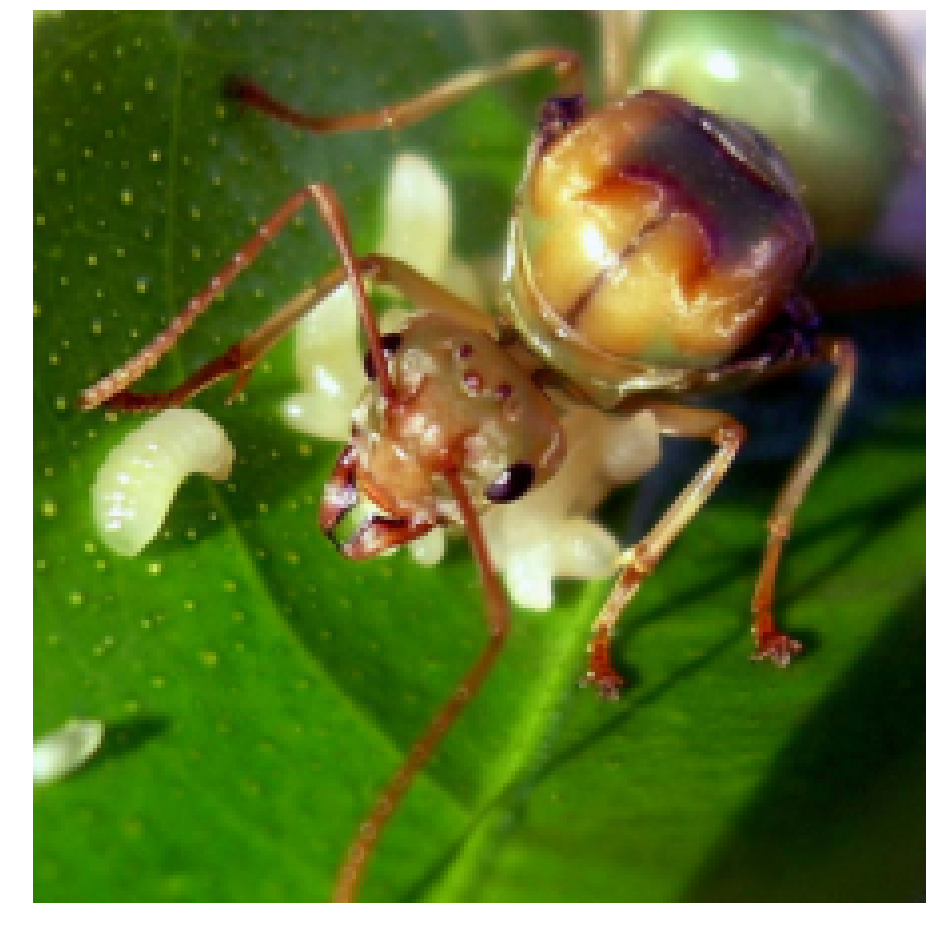

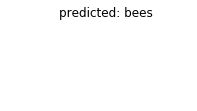

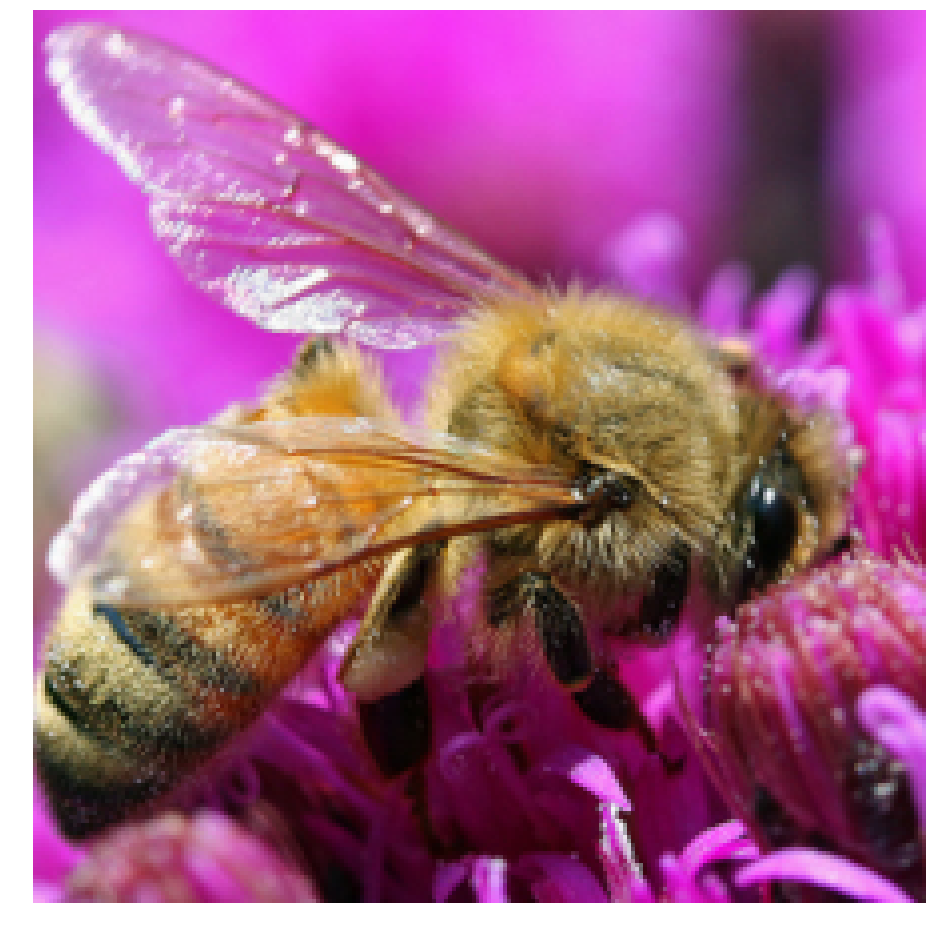

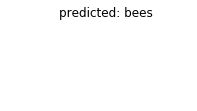

In [19]:
visualize_model(model_conv)